# Preprocess data

In [1]:
%run -m preprocess

Preprocess train-val data ...
	Read raw data ...
		Total samples: 32561
	Discard samples with missing features ...
		Samples without missing features: 30162
	Convert samples to feature vectors ...
		Normalize features ...
		Feature matrix dims: (30162, 105)
	Save features to npy file ...
	Read labels ...
		Labels matrix dims: (30162,)
		Percentage of positives: 24.89%
	Save labels to npy file ...
	Create train-val split ...
		Num train samples: 30162
		Num val samples: 0
	Save train and val sample ids ...
Preprocess test data ...
	Read raw data ...
		Total samples: 16281
	Discard samples with missing features ...
		Samples without missing features: 15060
	Convert samples to feature vectors ...
		Normalize features ...
		Feature matrix dims: (15060, 105)
	Save features to npy file ...
	Read labels ...
		Labels matrix dims: (15060,)
		Percentage of positives: 24.57%
	Save labels to npy file ...
	Save sample ids ...


In [2]:
import numpy as np

In [3]:
import copy
import torch
import torch.nn as nn


class IncomeClassifierConstants():
    def __init__(self):
        self.in_dim = 105
        self.hidden_dim = 105
        self.num_hidden_blocks = 2
        self.drop_prob = 0.2
        self.out_dim =2


class IncomeClassifier(nn.Module):
    def __init__(self,const):
        super().__init__()
        self.const = copy.deepcopy(const)

        if self.const.num_hidden_blocks==0:
            self.layers = nn.Linear(self.const.in_dim,self.const.out_dim)

        else:
            layers = []
            
            # Add input layers
            layers.append(self.input_block())
            
            # Add hidden layers
            for i in range(self.const.num_hidden_blocks):
                layers.append(self.hidden_block())
            
            # Add output layers
            layers.append(self.output_block())
            
            self.layers = nn.Sequential(*layers)

        self.softmax_layer = nn.Softmax(1)


    def input_block(self):
        return nn.Sequential(
            nn.Linear(self.const.in_dim,self.const.hidden_dim),
            nn.BatchNorm1d(self.const.hidden_dim),
            nn.Dropout(self.const.drop_prob),
            nn.Sigmoid())

    def hidden_block(self):
        return nn.Sequential(
            nn.Linear(self.const.hidden_dim,self.const.hidden_dim),
            nn.BatchNorm1d(self.const.hidden_dim),
            nn.Dropout(self.const.drop_prob),
            nn.Sigmoid())

    def output_block(self):
        return nn.Linear(self.const.hidden_dim,self.const.out_dim)

    def forward(self,x):
        logits = self.layers(x)
#         probs = self.softmax_layer(logits)
        return logits#, probs




In [4]:
x_train = np.load('income_proc/train_val_feat.npy')
y_train = np.load('income_proc/train_val_label.npy')
x_test = np.load('income_proc/test_feat.npy')
y_test = np.load('income_proc/test_label.npy')

In [5]:
x_train[:, 57]

array([ 0.6928689,  0.6928689,  0.6928689, ..., -1.4435358,  0.6928689,
       -1.4435358], dtype=float32)

# Partition data into clients

In [6]:
from matplotlib import pyplot as plt
import random
import numpy as np

def split_image_data_realwd(data, labels=2, n_clients=100, verbose=True):
  '''
  Splits (data, labels) among 'n_clients s.t. every client can holds any number of classes which is trying to simulate real world dataset
  Input:
    data : [n_data x shape]
    labels : [n_data (x 1)] from 0 to n_labels(10)
    n_clients : number of clients
    verbose : True/False => True for printing some info, False otherwise
  Output:
    clients_split : splitted client data into desired format
  '''
  def break_into(n,m):
    ''' 
    return m random integers with sum equal to n 
    '''
    to_ret = [1 for i in range(m)]
    for i in range(n-m):
        ind = random.randint(0,m-1)
        to_ret[ind] += 1
    return to_ret

  #### constants ####
  n_labels = 2
  n_classes = len(set(labels))
  classes = list(range(n_classes))
  np.random.shuffle(classes)
  #print('classes',classes)
  label_indcs  = [list(np.where(labels==class_)[0]) for class_ in classes]
  #print('label_indcs',label_indcs)
  
  #### classes for each client ####
  tmp = [np.random.randint(1,10) for i in range(n_clients)]
  #print(' temp',tmp)
  total_partition = sum(tmp)
  #print('total temp',total_partition)
  

  #### create partition among classes to fulfill criteria for clients ####
  class_partition = break_into(total_partition, len(classes))



  #### applying greedy approach first come and first serve ####
  class_partition = sorted(class_partition,reverse=True)
  #print('class_partition',class_partition)
  class_partition_split = {}

  #### based on class partition, partitioning the label indexes ###
  for ind, class_ in enumerate(classes):
      class_partition_split[class_] = [list(i) for i in np.array_split(label_indcs[ind],class_partition[ind])]
      
#   print([len(class_partition_split[key]) for key in  class_partition_split.keys()])
  #print('class_partition_split',class_partition_split)
  #print('lenth',len(class_partition_split))
  clients_split = []
  count = 0
  for i in range(n_clients):
    n = tmp[i]
    j = 0
    indcs = []

    while n>0:
        #print('n',n)
        class_ = classes[j]
        if len(class_partition_split[class_])>0:
            indcs.extend(class_partition_split[class_][-1])
            count+=len(class_partition_split[class_][-1])
            class_partition_split[class_].pop()
            n-=1
        j = (j+1) % n_classes

    ##### sorting classes based on the number of examples it has #####
    classes = sorted(classes,key=lambda x:len(class_partition_split[x]),reverse=True)
    if n>0:
        raise ValueError(" Unable to fulfill the criteria ")
    clients_split.append([data[indcs], labels[indcs]])
#   print(class_partition_split)
#   print("total example ",count)

  def print_split(clients_split): 
    width = 0.35
    plt.figure(figsize=(20, 10))
    columns = ['Client 1', 'Client 2', 'Client 3','Client 4','Client 5','Client 6','Client 7', 'Client 8','Client 9', 'Client 10','Client 11', 'Client 12','Client 13','Client 14','Client 15']
    clients = np.arange(n_clients)
    colors = ['red', 'yellow', 'black', 'blue', 'orange', 'navy','green','plum','cyan','purple']


    print("Data split:")
    
    all = []
    for i, client in enumerate(clients_split):
      split = np.sum(client[1].reshape(1,-1)==np.arange(n_labels).reshape(-1,1), axis=1)
      all.append(split)
      print(" - Client test {}: {}".format(i,split))

    
    
    all = np.array(all)
    all = np.transpose(all)
    for j in range (n_labels):
      if( j == 0):
        plt.bar(clients, all[j], color= colors[j],  edgecolor=colors,  width = width, label = "class %d " %j )
      elif (j == 1):
        plt.bar(clients,  all[j], color= colors[j],  edgecolor=colors,  bottom= all[j-1], width = width, label = "class %d" % j )
      else:
        plt.bar(clients,  all[j], color= colors[j],  edgecolor=colors,  bottom=sum(all[j] for j in range(j)) , width = width, label = "class %d" % j )

#     plt.xticks(clients, columns)
    plt.legend(loc='upper right')
    plt.show()
    print()
      
  if verbose:
    print_split(clients_split)
  
  clients_split = np.array(clients_split)
  
  return clients_split

Data split:
 - Client test 0: [11326  1500]
 - Client test 1: [5664  751]
 - Client test 2: [5664 1502]
 - Client test 3: [   0 3004]
 - Client test 4: [  0 751]


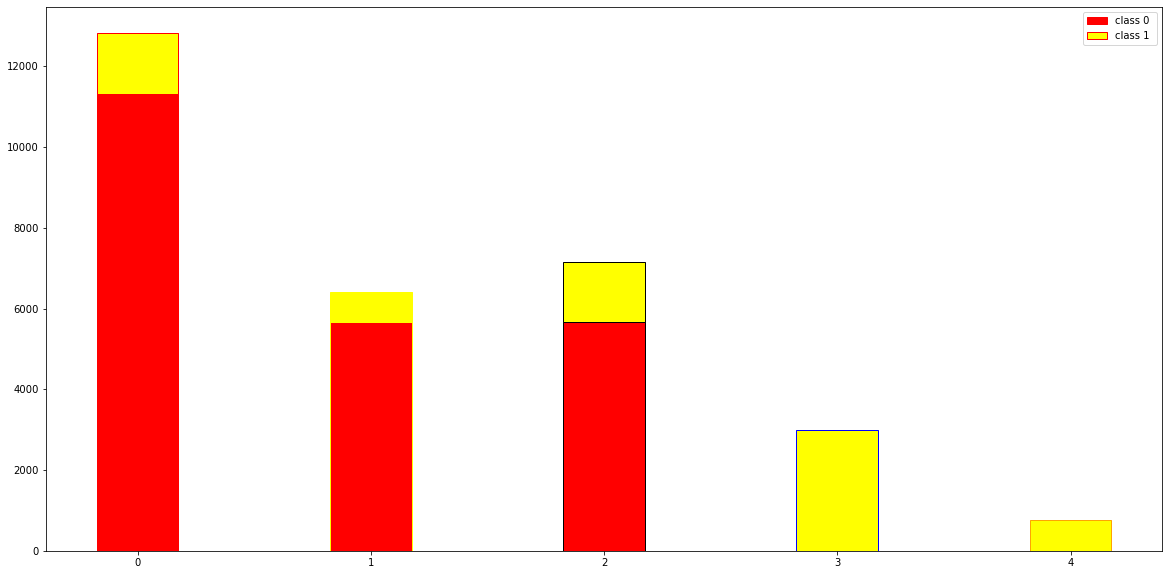

/scratch/local/12330076/ipykernel_44705/1122788558.py:120: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clients_split = np.array(clients_split)


In [7]:
clients_split = split_image_data_realwd(x_train, y_train, n_clients=5, verbose=True)

# Re-balance data

In [8]:
from income_attributes import *

ATTR_TO_IDX
female_ft_idx = ATTR_TO_IDX['Female']
male_ft_idx = ATTR_TO_IDX['Male']

def print_gender_cnt(clients_split, client_idx, gender_ft_idx=57):
    print('------- Label 0 -------')
    print('female', sum(clients_split[client_idx][0][np.where(clients_split[client_idx][1] == 0)[0]][:,gender_ft_idx] < 0)) # female, label 0
    print('male', sum(clients_split[client_idx][0][np.where(clients_split[client_idx][1] == 0)[0]][:,gender_ft_idx] > 0)) # male, label 0

    print('\n------- Label 1 -------')
    print('female', sum(clients_split[client_idx][0][np.where(clients_split[client_idx][1] == 1)[0]][:,gender_ft_idx] < 0)) # female, label 0
    print('male', sum(clients_split[client_idx][0][np.where(clients_split[client_idx][1] == 1)[0]][:,gender_ft_idx] > 0)) # male, label 0

In [9]:
def balance_gender(data, clients, ratio_male_female=4, n_clients=5, n_labels=2):
    """
    Assuming that num of males is always greater than num of females in data
    """
    new_data = []

    for i in range(n_clients):
        if i in clients:
            samples = []
            labels = []
            for j in range(n_labels):
                samples_label = data[i][0][np.where(data[i][1] == j)[0]] # samples that have label j
                num_females = np.sum(samples_label[:, 56] > 0)
                num_males = np.sum(samples_label[:, 57] > 0)

                num_iter =  min(int(num_males/ratio_male_female), num_females)
                samples.append(samples_label[np.where(samples_label[:,56] > 0)[0]][: 1*num_iter]) # female samples
                samples.append(samples_label[np.where(samples_label[:,57] > 0)[0]][: ratio_male_female*num_iter]) # male samples

                labels.append(np.repeat(j, min(num_females, 1 * num_iter) + min(num_males, ratio_male_female*num_iter)))
                

            samples = np.vstack(samples)
            labels = np.hstack(labels)
            new_data.append([samples, labels])
        else:
            new_data.append([data[i][0], data[i][1]])

    return np.array(new_data)

In [11]:
clients_split = balance_gender(clients_split, [0, 1, 2, 3, 4], 1, 5, 2)

/scratch/local/12330076/ipykernel_44705/1391985354.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_data)


# Training model

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.backends.cudnn.benchmark=True
    
device

'cuda'

In [18]:
#Hyper-paramters for FL
num_selected = num_clients = 5
num_rounds = 5
epochs = 5
batch_size= 32

In [20]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = [torch.utils.data.DataLoader(TensorDataset(torch.Tensor(clients_split[x][0]), torch.Tensor(clients_split[x][1])), batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True) 
                for x in range(num_clients)]
test_loader = torch.utils.data.DataLoader(
       TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test)) , batch_size=batch_size, shuffle=False, num_workers=4)

In [21]:
def client_update(client_model, optimizer, fn_loss, train_loader, epoch=5):
    """
    This function updates/trains client model on client data
    """
    client_model.train()
    for e in range(epoch):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            target = target.long() 
            optimizer.zero_grad()
            output = client_model(data)
            loss = fn_loss(output, target)
            loss.backward()
            optimizer.step()
    return loss.item()

In [22]:
def server_aggregate(global_model, client_models):
    """
    This function has aggregation method 'mean'
    """
    ### This will take simple mean of the weights of models ###
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float() for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

In [23]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [24]:
def test(global_model,fn_loss, test_loader):
    """This function test the global model on test data and returns test loss and test accuracy """
    global_model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = global_model(data)
            target = target.long() 
            test_loss += fn_loss(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc = correct / len(test_loader.dataset)

    return test_loss, acc

In [25]:
#### global model ##########
# global_model = BasicNet(num_features, 2).to(device)
model_const = IncomeClassifierConstants()
global_model = IncomeClassifier(model_const).to(device)


############## client models ##############
client_models = [ IncomeClassifier(model_const).to(device) for _ in range(num_selected)]

if device == 'cuda':
    global_model = torch.nn.DataParallel(global_model)
    client_models = [torch.nn.DataParallel(m) for m in client_models]

for model in client_models:
    model.load_state_dict(global_model.state_dict()) ### initial synchronizing with global model 

############### optimizers ################
import torch.optim as optim

opt = [optim.Adam(model.parameters(), lr=1e-3) for model in client_models]

criterion = nn.CrossEntropyLoss()

In [26]:
from tqdm import tqdm
###### List containing info about learning #########
losses_train = []
losses_test = []
acc_train = []
acc_test = []
# Runnining FL

for r in range(50):
    # client update
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i],criterion, train_loader[i], epoch=epochs)
    
    losses_train.append(loss)
    # server aggregate
    server_aggregate(global_model, client_models)
    
    test_loss, acc = test(global_model,criterion, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    print('%d-th round' % r)
    print('average train loss %0.3g | test loss %0.3g | test acc: %0.3f' % (loss / num_selected, test_loss, acc))



100%|█████████████████████████████████████████████| 5/5 [01:20<00:00, 16.10s/it]


0-th round
average train loss 0.155 | test loss 0.0154 | test acc: 0.815


100%|█████████████████████████████████████████████| 5/5 [00:46<00:00,  9.29s/it]


1-th round
average train loss 0.103 | test loss 0.0143 | test acc: 0.824


100%|█████████████████████████████████████████████| 5/5 [00:46<00:00,  9.31s/it]


2-th round
average train loss 0.0997 | test loss 0.0139 | test acc: 0.820


100%|█████████████████████████████████████████████| 5/5 [00:46<00:00,  9.36s/it]


3-th round
average train loss 0.0913 | test loss 0.0139 | test acc: 0.810


100%|█████████████████████████████████████████████| 5/5 [00:46<00:00,  9.33s/it]


4-th round
average train loss 0.106 | test loss 0.0136 | test acc: 0.807


  0%|                                                     | 0/5 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [27]:
check_accuracy(test_loader, global_model)

Got 12150 / 15060 with accuracy 80.68


# SHAP explainer

In [28]:
from captum.attr import (
    IntegratedGradients,
    DeepLift,
    DeepLiftShap,
    GradientShap,
    NoiseTunnel,
    FeatureAblation,
    Saliency,
    InputXGradient,
    Deconvolution,
    FeaturePermutation
)
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import NeuronConductance

### Global model

In [35]:
gs = GradientShap(global_model)
gs_attr_test = gs.attribute(torch.Tensor(x_test), torch.Tensor(x_train), target=1)

Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".


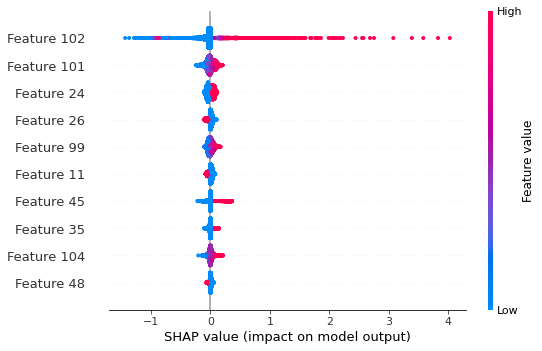

In [36]:
import shap 
shap.summary_plot(gs_attr_test.numpy(), x_test, max_display =10) 

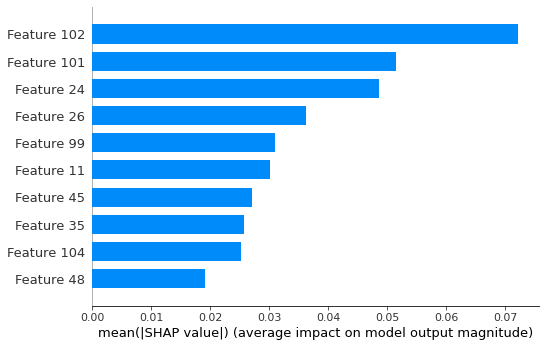

In [39]:
shap.summary_plot(gs_attr_test.numpy(), x_test, plot_type="bar", max_display = 10)

### Client models

In [34]:
for i in tqdm(range(num_selected)):
    loss += client_update(client_models[i], opt[i],criterion, train_loader[i], epoch=epochs)

100%|█████████████████████████████████████████████| 5/5 [00:47<00:00,  9.41s/it]


Using -1 to represent CPU tensor is deprecated. Please use a device object or string instead, e.g., "cpu".


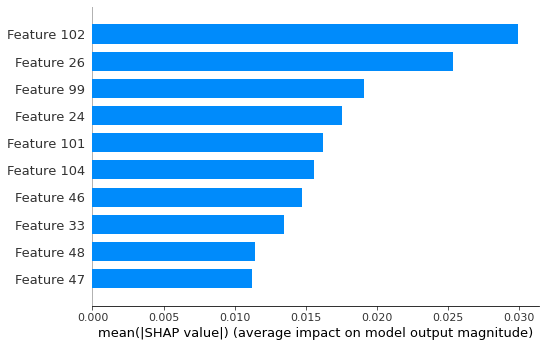

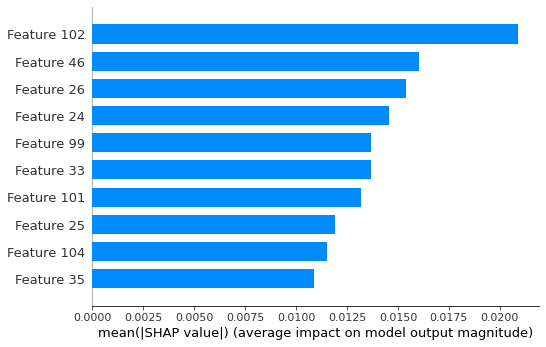

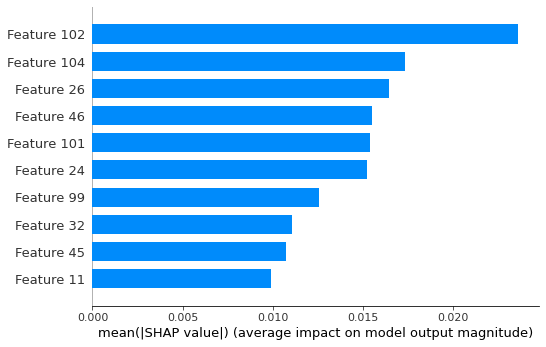

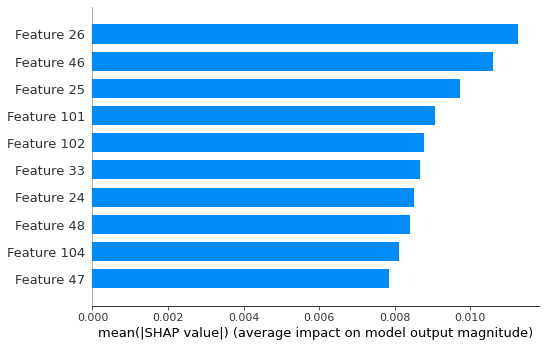

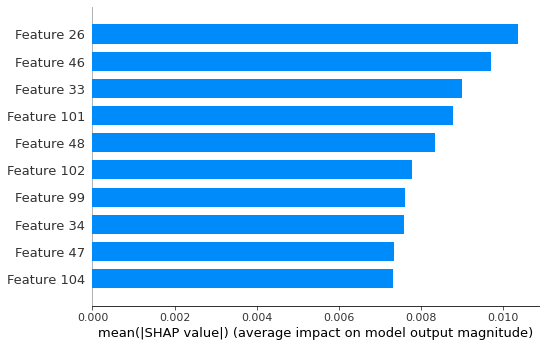

In [40]:
for i in range(num_clients):
    gs = GradientShap(client_models[i])
    gs_attr_test = gs.attribute(torch.Tensor(x_test), torch.Tensor(x_train), target=0)
    
    shap.summary_plot(gs_attr_test.numpy(), x_test, plot_type="bar", max_display = 10)